In [1]:
import os
import pickle as pkl
path = os.getcwd()

from joblib import Parallel, delayed
from src.est import *
from src.plt_utils import *
from time import perf_counter

SEED = 1000
num_cpus = os.cpu_count() // 2
np.random.seed(SEED)
os.environ['OMP_NUM_THREADS'] = str(num_cpus)
print(f"No. CPUs: {num_cpus}")

SAVE_DATA = True
SAVE_RESULTS = True
LOAD_DATA = False
LOAD_RESULTS = False

folder = "synth_comparison"
data_file = "data_2025-05-24-2000"
results_file = "results_2025-05-24-2000"


No. CPUs: 4


## Arguments

In [2]:
trials = 10

Is = torch.tensor([7,7,7])
D = len(Is)
I = torch.prod(Is).item()
K = 15
all2ten = (I**2 / (Is.sum()*2+1)).item()
all2mat = (I**2 / (I*2+1))

N = int(1e3)
burn_in = 500

# ---------------
qmin = 1e-6
qmax = 1.
tol = 1e-6
verbose = True
# ---------------

# ---------------
K_mat = int(K * all2mat/all2ten)
alpha_dc = 1e-1
beta_dc = 1.
gamma_dc = 1.
num_itrs_dc = 1000
num_inn_itrs_dc = 1

beta_nn = 1.
num_itrs_nn = 1000
# ---------------


# ---------------
K_ten = K
num_itrs_scpd = 10000
num_mttkrps = 200
slide_window = 1000
alpha_factor = 1e-1
alpha_weight = 1e-1
gamma_factor = 2e-1
gamma_weight = 2e-1
beta_scpd = 5e-1
eps = 1e-9
ALPHA_TYPE = "adam"

B_adam = lambda K: int(10 * K * np.log(K) / np.log(2))
B = 10 if ALPHA_TYPE!="adam" else B_adam(K)
B = 5
B_max = None
INCREASE_B = False
ACCELERATION = True
# ---------------

print(f"Ratio of tensor rank to states: {K/I:.2f}")
print(f"No. total parameters: {I**2}")
print(f"No. low-rank matrix parameters: {2*I+1} * K")
print(f"No. low-rank tensor parameters: {2*Is.sum()+1} * K")
print(f"Ratio of total to matrix: {all2mat:.2f}")
print(f"Ratio of total to tensor: {all2ten:.2f}")
print(f"")
print(f"Matrix rank {int(np.round(all2mat/all2ten * K))} <-> Tensor rank {K}")
print(f"Matrix parameters {(2*I+1) * int(np.round(all2mat/all2ten * K))} <-> Tensor parameters {K * (2*Is.sum()+1)}")


Ratio of tensor rank to states: 0.04
No. total parameters: 117649
No. low-rank matrix parameters: 687 * K
No. low-rank tensor parameters: 43 * K
Ratio of total to matrix: 171.25
Ratio of total to tensor: 2736.02

Matrix rank 1 <-> Tensor rank 15
Matrix parameters 687 <-> Tensor parameters 645


In [3]:
ipdc_args = {
    "K":K_mat,
    "alpha":alpha_dc,
    "beta":beta_dc,
    "gamma":gamma_dc,
    "pmin":qmin,
    "num_itrs":num_itrs_dc,
    "num_inn_itrs":num_inn_itrs_dc,
    "tol":tol,
    "inn_tol":tol,
    "verbose":verbose,
}

sgsadmm_args = {
    "K":K_mat,
    "beta":beta_nn,
    "pmin":qmin,
    "num_itrs":num_itrs_nn,
    "tol":tol,
    "verbose":verbose,
}

slrm_args = {
    "K":K_mat,
    "qmin":qmin,
}

scpdfib_args = {
    "SAMPLING_TYPE":'fiber',
    "K":K_ten,
    "qmin":qmin,
    "qmax":qmax,
    "num_itrs": num_mttkrps * int(torch.ceil(I*I/B/Is.min()).item()),
    "tol":tol,
    "slide_window":slide_window,
    "ALPHA_TYPE":ALPHA_TYPE,
    "alpha_factor":alpha_factor,
    "alpha_weight":alpha_weight,
    "gamma_factor":gamma_factor,
    "gamma_weight":gamma_weight,
    "beta":beta_scpd,
    "eps":eps,
    "B":B,
    "B_max":B_max,
    "INCREASE_B":INCREASE_B,
    "ACCELERATION":ACCELERATION,
}

scpdent_args = {
    "SAMPLING_TYPE":'entry',
    "K":K_ten,
    "qmin":qmin,
    "qmax":qmax,
    # "num_itrs": num_mttkrps * int(torch.ceil(I*I/B/Is.min()).item()),
    "num_itrs": num_itrs_scpd,
    "tol":tol,
    "slide_window":slide_window,
    "ALPHA_TYPE":ALPHA_TYPE,
    "alpha_factor":alpha_factor * 1e-0,
    "alpha_weight":alpha_weight * 1e-0,
    "gamma_factor":gamma_factor,
    "gamma_weight":gamma_weight,
    "beta":beta_scpd,
    "eps":eps,
    "B":B,
    "B_max":B_max,
    "INCREASE_B":INCREASE_B,
    "ACCELERATION":ACCELERATION,
}

scpdtraj_args = {
    "SAMPLING_TYPE":'trajectory',
    "K":K_ten,
    "qmin":qmin,
    "qmax":qmax,
    # "num_itrs": num_mttkrps * int(torch.ceil(I*I/B/Is.min()).item()),
    "num_itrs": num_itrs_scpd,
    "tol":tol,
    "slide_window":slide_window,
    "ALPHA_TYPE":ALPHA_TYPE,
    "alpha_factor":alpha_factor * 1e-0,
    "alpha_weight":alpha_weight * 1e-0,
    "gamma_factor":gamma_factor,
    "gamma_weight":gamma_weight,
    "beta":beta_scpd,
    "eps":eps,
    "B":B,
    "B_max":B_max,
    "INCREASE_B":INCREASE_B,
    "ACCELERATION":ACCELERATION,
}


## Generate data

Data has been saved to synth_comparison/data_2025-05-24-2000


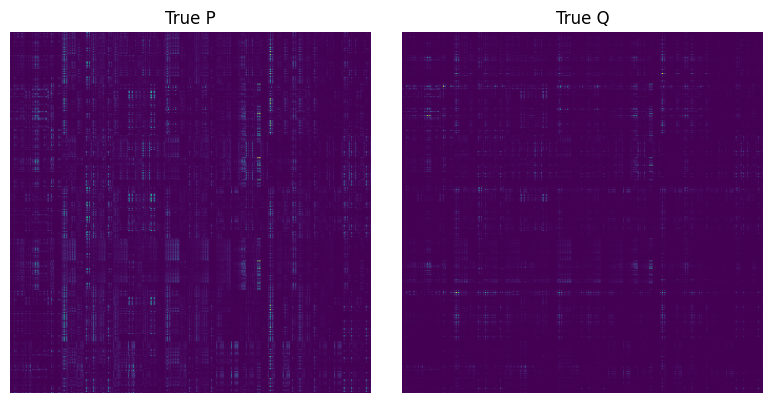

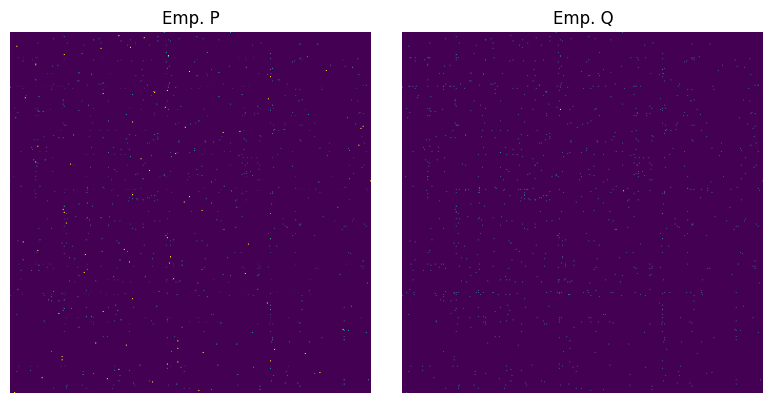

In [4]:
mc = [generate_lowranktensor_model(Is,K) for t in range(trials)]
X = [mc[t].simulate(N+burn_in)[burn_in:] for t in range(trials)]
P_emp = [estimate_empirical_tensor(X[t],Is)[0] for t in range(trials)]
mc_emp = [MarkovChainTensor(P_emp[t]) for t in range(trials)]

if LOAD_DATA:
    data_path = os.path.join(folder,data_file)
    assert os.path.exists(data_path), f"Data file {data_path} does not exist."    
    with open(data_path,"rb") as f:
        loaded_data = pkl.load(f)
        print(f"Data has been loaded from {data_path}.")

    trials = len(mc)
    assert trials==len(mc_emp) and trials==len(X), "Inconsistent number of trials."

    mc = [MarkovChainTensor(loaded_data["P"][t]) for t in range(trials)]
    mc_emp = [MarkovChainTensor(loaded_data["P_emp"][t]) for t in range(trials)]
    X = [loaded_data["X"][t] for t in range(trials)]
if SAVE_DATA:
    if not os.path.exists(folder):
        os.mkdir(folder)

    data = {
        "P":[mc[t].P for t in range(trials)],
        "P_emp":[mc_emp[t].P for t in range(trials)],
        "X":[X[t] for t in range(trials)],
    }

    data_path = os.path.join(folder,data_file)
    with open(data_path,"wb") as f:
        pkl.dump(data,f)
        print(f"Data has been saved to {data_path}")

mc = [MarkovChainMatrix(ten2mat(mc[t].P,I)) for t in range(trials)]
mc_emp = [MarkovChainMatrix(ten2mat(mc_emp[t].P,I)) for t in range(trials)]

t = 0
fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); 
ax[0].imshow( mc[t].P )
ax[0].axis('off'); ax[0].set_title("True P")
ax[1].imshow( mc[t].Q )
ax[1].axis('off'); ax[1].set_title("True Q")
fig.tight_layout()

fig = plt.figure(figsize=(2*4,4)); ax = fig.subplots(1,2); 
ax[0].imshow( mc_emp[t].P )
ax[0].axis('off'); ax[0].set_title("Emp. P")
ax[1].imshow( mc_emp[t].Q )
ax[1].axis('off'); ax[1].set_title("Emp. Q")
fig.tight_layout()



## Estimate Markov chain

In [5]:
def scpd_parallel(X,mc,args):
    results = SCPD(X, mat2ten(mc.Q,Is), **args)
    return (results['mc_est'], results['diffs'], results['costs'])


### Compare fiber SCPD with and without acceleration

In [6]:
scpdfib_args_w_accel = scpdfib_args.copy(); scpdfib_args_w_accel["ACCELERATION"] = True
scpdfib_args_wo_accel = scpdfib_args.copy(); scpdfib_args_wo_accel["ACCELERATION"] = False

print(f"SCPD - {scpdfib_args['SAMPLING_TYPE']} - With acceleration")
results_w_accel = Parallel(n_jobs=num_cpus)(delayed(scpd_parallel)( X[t], mc_emp[t], scpdfib_args_w_accel ) for t in range(trials))
mc_w_accel, diffs_w_accel, costs_w_accel = tuple(zip(*results_w_accel))
mc_w_accel = [MarkovChainMatrix(ten2mat(mc_w_accel[t].P,I)) for t in range(trials)]

print(f"SCPD - {scpdfib_args['SAMPLING_TYPE']} - Without acceleration")
results_wo_accel = Parallel(n_jobs=num_cpus)(delayed(scpd_parallel)( X[t], mc_emp[t], scpdfib_args_wo_accel ) for t in range(trials))
mc_wo_accel, diffs_wo_accel, costs_wo_accel = tuple(zip(*results_wo_accel))
mc_wo_accel = [MarkovChainMatrix(ten2mat(mc_wo_accel[t].P,I)) for t in range(trials)]

kld_P_w_accel = torch.FloatTensor([kld_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
kld_Q_w_accel = torch.FloatTensor([kld_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
kld_R_w_accel = torch.FloatTensor([kld_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])
normfrob_P_w_accel = torch.FloatTensor([normfrob_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
normfrob_Q_w_accel = torch.FloatTensor([normfrob_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
normfrob_R_w_accel = torch.FloatTensor([normfrob_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])
norml1_P_w_accel = torch.FloatTensor([norml1_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
norml1_Q_w_accel = torch.FloatTensor([norml1_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
norml1_R_w_accel = torch.FloatTensor([norml1_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])

kld_P_wo_accel = torch.FloatTensor([kld_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
kld_Q_wo_accel = torch.FloatTensor([kld_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
kld_R_wo_accel = torch.FloatTensor([kld_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])
normfrob_P_wo_accel = torch.FloatTensor([normfrob_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
normfrob_Q_wo_accel = torch.FloatTensor([normfrob_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
normfrob_R_wo_accel = torch.FloatTensor([normfrob_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])
norml1_P_wo_accel = torch.FloatTensor([norml1_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
norml1_Q_wo_accel = torch.FloatTensor([norml1_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
norml1_R_wo_accel = torch.FloatTensor([norml1_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])

print(f"KLD P - with accel.:    {kld_P_w_accel.mean():.5f} ± {kld_P_w_accel.std():.5f}")
print(f"KLD P - without accel.: {kld_P_wo_accel.mean():.5f} ± {kld_P_wo_accel.std():.5f}")
print("")

print(f"KLD Q - with accel.:    {kld_Q_w_accel.mean():.5f} ± {kld_Q_w_accel.std():.5f}")
print(f"KLD Q - without accel.: {kld_Q_wo_accel.mean():.5f} ± {kld_Q_wo_accel.std():.5f}")
print("")

print(f"KLD R - with accel.:    {kld_R_w_accel.mean():.5f} ± {kld_R_w_accel.std():.5f}")
print(f"KLD R - without accel.: {kld_R_wo_accel.mean():.5f} ± {kld_R_wo_accel.std():.5f}")
print("")

print("")

print(f"Frob. err. P - with accel.:    {normfrob_P_w_accel.mean():.5f} ± {normfrob_P_w_accel.std():.5f}")
print(f"Frob. err. P - without accel.: {normfrob_P_wo_accel.mean():.5f} ± {normfrob_P_wo_accel.std():.5f}")
print("")

print(f"Frob. err. Q - with accel.:    {normfrob_Q_w_accel.mean():.5f} ± {normfrob_Q_w_accel.std():.5f}")
print(f"Frob. err. Q - without accel.: {normfrob_Q_wo_accel.mean():.5f} ± {normfrob_Q_wo_accel.std():.5f}")
print("")

print(f"Frob. err. R - with accel.:    {normfrob_R_w_accel.mean():.5f} ± {normfrob_R_w_accel.std():.5f}")
print(f"Frob. err. R - without accel.: {normfrob_R_wo_accel.mean():.5f} ± {normfrob_R_wo_accel.std():.5f}")
print("")

print("")

print(f"L1 err. P - with accel.:    {norml1_P_w_accel.mean():.5f} ± {norml1_P_w_accel.std():.5f}")
print(f"L1 err. P - without accel.: {norml1_P_wo_accel.mean():.5f} ± {norml1_P_wo_accel.std():.5f}")
print("")

print(f"L1 err. Q - with accel.:    {norml1_Q_w_accel.mean():.5f} ± {norml1_Q_w_accel.std():.5f}")
print(f"L1 err. Q - without accel.: {norml1_Q_wo_accel.mean():.5f} ± {norml1_Q_wo_accel.std():.5f}")
print("")

print(f"L1 err. R - with accel.:    {norml1_R_w_accel.mean():.5f} ± {norml1_R_w_accel.std():.5f}")
print(f"L1 err. R - without accel.: {norml1_R_wo_accel.mean():.5f} ± {norml1_R_wo_accel.std():.5f}")
print("")



SCPD - fiber - With acceleration
MTTKRP: 1/200 | Cost: 4.989e+00 | Diff: 3.6e-05 | Var: 0.0e+00 | af: 2.0e+01 | aw: 1.0e-01
MTTKRP: 1/200 | Cost: 5.003e+00 | Diff: 3.5e-05 | Var: 0.0e+00 | af: 2.3e+01 | aw: 1.0e-01
MTTKRP: 1/200 | Cost: 5.050e+00 | Diff: 3.5e-05 | Var: 0.0e+00 | af: 2.2e+01 | aw: 1.0e-01
MTTKRP: 1/200 | Cost: 5.072e+00 | Diff: 1.8e-05 | Var: 0.0e+00 | af: 1.9e+01 | aw: 1.0e-01
MTTKRP: 1/200 | Cost: 5.046e+00 | Diff: 7.2e-06 | Var: 0.0e+00 | af: 7.3e-01 | aw: 1.2e+00
MTTKRP: 1/200 | Cost: 4.994e+00 | Diff: 1.9e-06 | Var: 0.0e+00 | af: 7.3e-01 | aw: 7.3e-01
MTTKRP: 1/200 | Cost: 4.987e+00 | Diff: 1.6e-06 | Var: 0.0e+00 | af: 7.0e-01 | aw: 1.6e+00
MTTKRP: 1/200 | Cost: 5.067e+00 | Diff: 1.1e-06 | Var: 0.0e+00 | af: 6.2e-01 | aw: 2.2e+00
MTTKRP: 1/200 | Cost: 5.043e+00 | Diff: 9.9e-07 | Var: 0.0e+00 | af: 4.3e-01 | aw: 7.6e-01
MTTKRP: 1/200 | Cost: 4.992e+00 | Diff: 3.8e-07 | Var: 0.0e+00 | af: 4.0e-01 | aw: 6.4e-01
MTTKRP: 1/200 | Cost: 5.064e+00 | Diff: 5.2e-07 | Var: 0.

### Compare entry SCPD with and without acceleration

In [7]:
scpdent_args_w_accel = scpdent_args.copy(); scpdent_args_w_accel["ACCELERATION"] = True
scpdent_args_wo_accel = scpdent_args.copy(); scpdent_args_wo_accel["ACCELERATION"] = False

print(f"SCPD - {scpdent_args['SAMPLING_TYPE']} - With acceleration")
results_w_accel = Parallel(n_jobs=num_cpus)(delayed(scpd_parallel)( X[t], mc_emp[t], scpdent_args_w_accel ) for t in range(trials))
mc_w_accel, diffs_w_accel, costs_w_accel = tuple(zip(*results_w_accel))
mc_w_accel = [MarkovChainMatrix(ten2mat(mc_w_accel[t].P,I)) for t in range(trials)]

print(f"SCPD - {scpdent_args['SAMPLING_TYPE']} - Without acceleration")
results_wo_accel = Parallel(n_jobs=num_cpus)(delayed(scpd_parallel)( X[t], mc_emp[t], scpdent_args_wo_accel ) for t in range(trials))
mc_wo_accel, diffs_wo_accel, costs_wo_accel = tuple(zip(*results_wo_accel))
mc_wo_accel = [MarkovChainMatrix(ten2mat(mc_wo_accel[t].P,I)) for t in range(trials)]

kld_P_w_accel = torch.FloatTensor([kld_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
kld_Q_w_accel = torch.FloatTensor([kld_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
kld_R_w_accel = torch.FloatTensor([kld_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])
normfrob_P_w_accel = torch.FloatTensor([normfrob_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
normfrob_Q_w_accel = torch.FloatTensor([normfrob_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
normfrob_R_w_accel = torch.FloatTensor([normfrob_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])
norml1_P_w_accel = torch.FloatTensor([norml1_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
norml1_Q_w_accel = torch.FloatTensor([norml1_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
norml1_R_w_accel = torch.FloatTensor([norml1_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])

kld_P_wo_accel = torch.FloatTensor([kld_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
kld_Q_wo_accel = torch.FloatTensor([kld_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
kld_R_wo_accel = torch.FloatTensor([kld_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])
normfrob_P_wo_accel = torch.FloatTensor([normfrob_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
normfrob_Q_wo_accel = torch.FloatTensor([normfrob_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
normfrob_R_wo_accel = torch.FloatTensor([normfrob_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])
norml1_P_wo_accel = torch.FloatTensor([norml1_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
norml1_Q_wo_accel = torch.FloatTensor([norml1_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
norml1_R_wo_accel = torch.FloatTensor([norml1_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])

print(f"KLD P - with accel.:    {kld_P_w_accel.mean():.5f} ± {kld_P_w_accel.std():.5f}")
print(f"KLD P - without accel.: {kld_P_wo_accel.mean():.5f} ± {kld_P_wo_accel.std():.5f}")
print("")

print(f"KLD Q - with accel.:    {kld_Q_w_accel.mean():.5f} ± {kld_Q_w_accel.std():.5f}")
print(f"KLD Q - without accel.: {kld_Q_wo_accel.mean():.5f} ± {kld_Q_wo_accel.std():.5f}")
print("")

print(f"KLD R - with accel.:    {kld_R_w_accel.mean():.5f} ± {kld_R_w_accel.std():.5f}")
print(f"KLD R - without accel.: {kld_R_wo_accel.mean():.5f} ± {kld_R_wo_accel.std():.5f}")
print("")

print("")

print(f"Frob. err. P - with accel.:    {normfrob_P_w_accel.mean():.5f} ± {normfrob_P_w_accel.std():.5f}")
print(f"Frob. err. P - without accel.: {normfrob_P_wo_accel.mean():.5f} ± {normfrob_P_wo_accel.std():.5f}")
print("")

print(f"Frob. err. Q - with accel.:    {normfrob_Q_w_accel.mean():.5f} ± {normfrob_Q_w_accel.std():.5f}")
print(f"Frob. err. Q - without accel.: {normfrob_Q_wo_accel.mean():.5f} ± {normfrob_Q_wo_accel.std():.5f}")
print("")

print(f"Frob. err. R - with accel.:    {normfrob_R_w_accel.mean():.5f} ± {normfrob_R_w_accel.std():.5f}")
print(f"Frob. err. R - without accel.: {normfrob_R_wo_accel.mean():.5f} ± {normfrob_R_wo_accel.std():.5f}")
print("")

print("")

print(f"L1 err. P - with accel.:    {norml1_P_w_accel.mean():.5f} ± {norml1_P_w_accel.std():.5f}")
print(f"L1 err. P - without accel.: {norml1_P_wo_accel.mean():.5f} ± {norml1_P_wo_accel.std():.5f}")
print("")

print(f"L1 err. Q - with accel.:    {norml1_Q_w_accel.mean():.5f} ± {norml1_Q_w_accel.std():.5f}")
print(f"L1 err. Q - without accel.: {norml1_Q_wo_accel.mean():.5f} ± {norml1_Q_wo_accel.std():.5f}")
print("")

print(f"L1 err. R - with accel.:    {norml1_R_w_accel.mean():.5f} ± {norml1_R_w_accel.std():.5f}")
print(f"L1 err. R - without accel.: {norml1_R_wo_accel.mean():.5f} ± {norml1_R_wo_accel.std():.5f}")
print("")



SCPD - entry - With acceleration
MTTKRP: 1/1 | Cost: 4.966e+00 | Diff: 1.3e-01 | Var: 0.0e+00 | af: 6.1e-03 | aw: 1.0e-01
MTTKRP: 1/1 | Cost: 4.847e+00 | Diff: 9.7e-02 | Var: 0.0e+00 | af: 1.1e-02 | aw: 1.0e-01
MTTKRP: 1/1 | Cost: 5.063e+00 | Diff: 3.0e-02 | Var: 0.0e+00 | af: 1.5e-02 | aw: 1.0e-01
MTTKRP: 1/1 | Cost: 4.999e+00 | Diff: 5.6e-01 | Var: 0.0e+00 | af: 1.0e-01 | aw: 5.9e-03
MTTKRP: 1/1 | Cost: 5.025e+00 | Diff: 4.4e-02 | Var: 0.0e+00 | af: 1.1e-03 | aw: 6.1e-04
MTTKRP: 1/1 | Cost: 5.130e+00 | Diff: 1.1e-02 | Var: 0.0e+00 | af: 9.0e-04 | aw: 6.8e-04
MTTKRP: 1/1 | Cost: 5.208e+00 | Diff: 2.9e-02 | Var: 0.0e+00 | af: 9.4e-04 | aw: 3.6e-04
MTTKRP: 1/1 | Cost: 5.951e+00 | Diff: 1.6e-02 | Var: 0.0e+00 | af: 5.2e-04 | aw: 4.3e-04
MTTKRP: 1/1 | Cost: 4.887e+00 | Diff: 1.6e-03 | Var: 0.0e+00 | af: 7.0e-04 | aw: 4.7e-04
MTTKRP: 1/1 | Cost: 5.717e+00 | Diff: 7.9e-03 | Var: 0.0e+00 | af: 6.7e-04 | aw: 4.9e-04
MTTKRP: 1/1 | Cost: 4.907e+00 | Diff: 5.0e-03 | Var: 0.0e+00 | af: 5.0e-04 | 

### Compare trajectory SCPD with and without acceleration

In [8]:
scpdtraj_args_w_accel = scpdtraj_args.copy(); scpdtraj_args_w_accel["ACCELERATION"] = True
scpdtraj_args_wo_accel = scpdtraj_args.copy(); scpdtraj_args_wo_accel["ACCELERATION"] = False

print(f"SCPD - {scpdtraj_args['SAMPLING_TYPE']} - With acceleration")
results_w_accel = Parallel(n_jobs=num_cpus)(delayed(scpd_parallel)( X[t], mc_emp[t], scpdtraj_args_w_accel ) for t in range(trials))
mc_w_accel, diffs_w_accel, costs_w_accel = tuple(zip(*results_w_accel))
mc_w_accel = [MarkovChainMatrix(ten2mat(mc_w_accel[t].P,I)) for t in range(trials)]

print(f"SCPD - {scpdtraj_args['SAMPLING_TYPE']} - Without acceleration")
results_wo_accel = Parallel(n_jobs=num_cpus)(delayed(scpd_parallel)( X[t], mc_emp[t], scpdtraj_args_wo_accel ) for t in range(trials))
mc_wo_accel, diffs_wo_accel, costs_wo_accel = tuple(zip(*results_wo_accel))
mc_wo_accel = [MarkovChainMatrix(ten2mat(mc_wo_accel[t].P,I)) for t in range(trials)]

kld_P_w_accel = torch.FloatTensor([kld_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
kld_Q_w_accel = torch.FloatTensor([kld_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
kld_R_w_accel = torch.FloatTensor([kld_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])
normfrob_P_w_accel = torch.FloatTensor([normfrob_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
normfrob_Q_w_accel = torch.FloatTensor([normfrob_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
normfrob_R_w_accel = torch.FloatTensor([normfrob_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])
norml1_P_w_accel = torch.FloatTensor([norml1_err(mc[t].P,mc_w_accel[t].P) for t in range(trials)])
norml1_Q_w_accel = torch.FloatTensor([norml1_err(mc[t].Q,mc_w_accel[t].Q) for t in range(trials)])
norml1_R_w_accel = torch.FloatTensor([norml1_err(mc[t].R,mc_w_accel[t].R) for t in range(trials)])

kld_P_wo_accel = torch.FloatTensor([kld_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
kld_Q_wo_accel = torch.FloatTensor([kld_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
kld_R_wo_accel = torch.FloatTensor([kld_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])
normfrob_P_wo_accel = torch.FloatTensor([normfrob_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
normfrob_Q_wo_accel = torch.FloatTensor([normfrob_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
normfrob_R_wo_accel = torch.FloatTensor([normfrob_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])
norml1_P_wo_accel = torch.FloatTensor([norml1_err(mc[t].P,mc_wo_accel[t].P) for t in range(trials)])
norml1_Q_wo_accel = torch.FloatTensor([norml1_err(mc[t].Q,mc_wo_accel[t].Q) for t in range(trials)])
norml1_R_wo_accel = torch.FloatTensor([norml1_err(mc[t].R,mc_wo_accel[t].R) for t in range(trials)])

print(f"KLD P - with accel.:    {kld_P_w_accel.mean():.5f} ± {kld_P_w_accel.std():.5f}")
print(f"KLD P - without accel.: {kld_P_wo_accel.mean():.5f} ± {kld_P_wo_accel.std():.5f}")
print("")

print(f"KLD Q - with accel.:    {kld_Q_w_accel.mean():.5f} ± {kld_Q_w_accel.std():.5f}")
print(f"KLD Q - without accel.: {kld_Q_wo_accel.mean():.5f} ± {kld_Q_wo_accel.std():.5f}")
print("")

print(f"KLD R - with accel.:    {kld_R_w_accel.mean():.5f} ± {kld_R_w_accel.std():.5f}")
print(f"KLD R - without accel.: {kld_R_wo_accel.mean():.5f} ± {kld_R_wo_accel.std():.5f}")
print("")

print("")

print(f"Frob. err. P - with accel.:    {normfrob_P_w_accel.mean():.5f} ± {normfrob_P_w_accel.std():.5f}")
print(f"Frob. err. P - without accel.: {normfrob_P_wo_accel.mean():.5f} ± {normfrob_P_wo_accel.std():.5f}")
print("")

print(f"Frob. err. Q - with accel.:    {normfrob_Q_w_accel.mean():.5f} ± {normfrob_Q_w_accel.std():.5f}")
print(f"Frob. err. Q - without accel.: {normfrob_Q_wo_accel.mean():.5f} ± {normfrob_Q_wo_accel.std():.5f}")
print("")

print(f"Frob. err. R - with accel.:    {normfrob_R_w_accel.mean():.5f} ± {normfrob_R_w_accel.std():.5f}")
print(f"Frob. err. R - without accel.: {normfrob_R_wo_accel.mean():.5f} ± {normfrob_R_wo_accel.std():.5f}")
print("")

print("")

print(f"L1 err. P - with accel.:    {norml1_P_w_accel.mean():.5f} ± {norml1_P_w_accel.std():.5f}")
print(f"L1 err. P - without accel.: {norml1_P_wo_accel.mean():.5f} ± {norml1_P_wo_accel.std():.5f}")
print("")

print(f"L1 err. Q - with accel.:    {norml1_Q_w_accel.mean():.5f} ± {norml1_Q_w_accel.std():.5f}")
print(f"L1 err. Q - without accel.: {norml1_Q_wo_accel.mean():.5f} ± {norml1_Q_wo_accel.std():.5f}")
print("")

print(f"L1 err. R - with accel.:    {norml1_R_w_accel.mean():.5f} ± {norml1_R_w_accel.std():.5f}")
print(f"L1 err. R - without accel.: {norml1_R_wo_accel.mean():.5f} ± {norml1_R_wo_accel.std():.5f}")
print("")



SCPD - trajectory - With acceleration
MTTKRP: 1/1 | Cost: 4.938e+00 | Diff: 2.0e-02 | Var: 0.0e+00 | af: 4.1e-02 | aw: 1.0e-01MTTKRP: 1/1 | Cost: 5.040e+00 | Diff: 1.8e-02 | Var: 0.0e+00 | af: 3.6e-02 | aw: 1.0e-01
MTTKRP: 1/1 | Cost: 4.927e+00 | Diff: 1.1e-01 | Var: 0.0e+00 | af: 1.0e-01 | aw: 2.5e-02

MTTKRP: 1/1 | Cost: 4.951e+00 | Diff: 2.6e-02 | Var: 0.0e+00 | af: 3.6e-02 | aw: 1.0e-01
MTTKRP: 1/1 | Cost: 4.707e+00 | Diff: 3.0e-03 | Var: 0.0e+00 | af: 4.5e-03 | aw: 3.3e-03
MTTKRP: 1/1 | Cost: 4.760e+00 | Diff: 2.9e-03 | Var: 0.0e+00 | af: 4.7e-03 | aw: 3.5e-03
MTTKRP: 1/1 | Cost: 4.548e+00 | Diff: 2.8e-03 | Var: 0.0e+00 | af: 5.0e-03 | aw: 3.4e-03
MTTKRP: 1/1 | Cost: 4.644e+00 | Diff: 3.3e-03 | Var: 0.0e+00 | af: 4.6e-03 | aw: 3.4e-03
MTTKRP: 1/1 | Cost: 4.653e+00 | Diff: 3.2e-03 | Var: 0.0e+00 | af: 3.4e-03 | aw: 2.3e-03
MTTKRP: 1/1 | Cost: 4.707e+00 | Diff: 1.6e-03 | Var: 0.0e+00 | af: 3.1e-03 | aw: 2.4e-03
MTTKRP: 1/1 | Cost: 4.571e+00 | Diff: 2.2e-03 | Var: 0.0e+00 | af: 3.3e-